 # If using Colab

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/ISY5004')
# print(os.getcwd())


 # Configuration

In [1]:
import math
baseModelName = "FRCNN"
base_net_type = 'vgg'   # either 'vgg' or 'resnet50'
modelName = baseModelName + "_" + base_net_type
model_path = modelName + ".hdf5"
csv_path = modelName + ".csv"

num_epochs = 40

im_size = 300                       # shorter-side length. Original is 600, half it to save training time
anchor_box_scales = [64,128,256]    # also half box_scales accordingly. Original is [128,256,512]
anchor_box_ratios = [[1,1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]] # anchor box ratios area == 1
num_rois = 4


 # Load data

In [2]:
from FRCNN import parseAnnotationFile
annotation_train_path = './annotation_train.txt'
train_data, classes_count, class_mapping = parseAnnotationFile(annotation_train_path)


Parsing annotation files
idx=3083
Spend 0.02 mins to load the data


 ## Inspect annotation file with a sample image

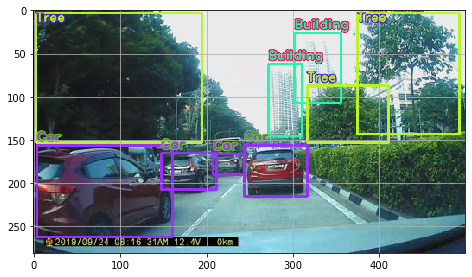

In [4]:
from FRCNN import viewAnnotatedImage
viewAnnotatedImage(annotation_train_path, 'resize/train/image100.jpg', class_mapping)


 # Create and Train FRCNN model

 ## Create

In [5]:
from FRCNN import FRCNN
num_anchors = len(anchor_box_scales) * len(anchor_box_ratios)
frcnn = FRCNN(input_shape=(None,None,3), num_anchors=num_anchors, num_rois=num_rois, base_net_type=base_net_type, num_classes = len(classes_count))
frcnn.compile()


 ## Visualise

In [6]:
frcnn.model_rpn.summary()
frcnn.summary()

# Plot structure of FRCNN
from tensorflow.keras.utils import plot_model
plot_model(frcnn.model_all, to_file=modelName+'.png', show_shapes=True, show_layer_names=False, rankdir='TB')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1a (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1a (Conv2D)          (None, None, None, 6 1792        input_1a[0][0]                   
__________________________________________________________________________________________________
block1_conv2a (Conv2D)          (None, None, None, 6 36928       block1_conv1a[0][0]              
__________________________________________________________________________________________________
block1_poola (MaxPooling2D)     (None, None, None, 6 0           block1_conv2a[0][0]              
__________________________________________________________________________________________________
block2_con

 ## Train

In [0]:
## create iterator
from FRCNN import FRCNNGenerator, inspect
train_it = FRCNNGenerator(train_data,
    target_size= im_size, std_scaling=4,
    horizontal_flip=True, vertical_flip = False, rotation_range = 0, shuffle=False, base_net_type=base_net_type
)

inspect(train_it, im_size)


In [0]:
# train model - will automatically resume training if csv and model already exists
frcnn.fit_generator(train_it, target_size = im_size, class_mapping = class_mapping, epochs=num_epochs, model_path=model_path, csv_path=csv_path)



 # Examine Performance

 # Test FRCNN model

Parsing annotation files
idx=3083
Spend 0.02 mins to load the data
Parsing annotation files
idx=2880
Spend 0.01 mins to load the data
1/105 - resize/test/image1000.jpg
Elapsed time = 5.927670955657959
[('Building', 99.99346733093262), ('Building', 99.15761351585388), ('Car', 96.68857455253601)]


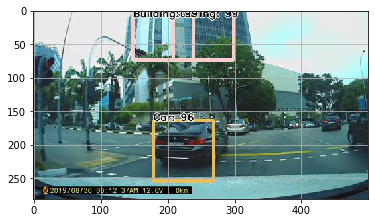

2/105 - resize/test/image1001.jpg
Elapsed time = 3.3291473388671875
[('Building', 99.55331087112427)]


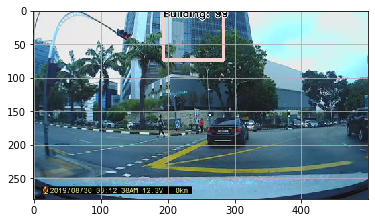

3/105 - resize/test/image1002.jpg
Elapsed time = 3.606390953063965
[('Building', 96.55871391296387), ('Tree', 95.29619812965393)]


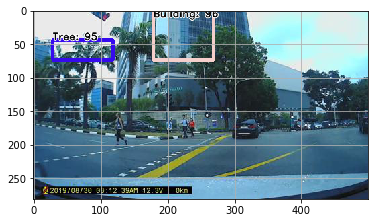

4/105 - resize/test/image1003.jpg
Elapsed time = 3.604438066482544
[('Building', 97.41451144218445), ('Building', 71.22653126716614), ('Tree', 78.08956503868103)]


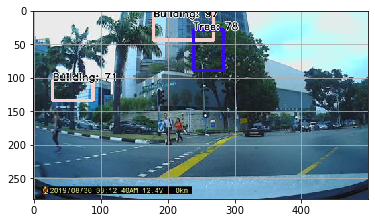

5/105 - resize/test/image1004.jpg
Elapsed time = 3.609523057937622
[('Building', 72.3534345626831)]


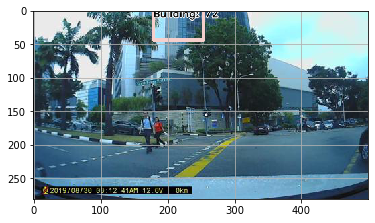

6/105 - resize/test/image1005.jpg
Elapsed time = 3.882619619369507
[('Building', 82.7556848526001), ('Car', 92.57943630218506)]


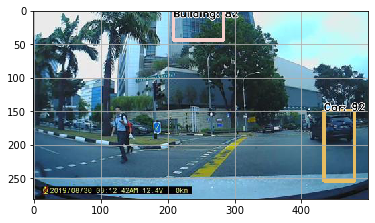

7/105 - resize/test/image1006.jpg
Elapsed time = 3.5315263271331787
[('Building', 84.60203409194946), ('Car', 71.99488282203674)]


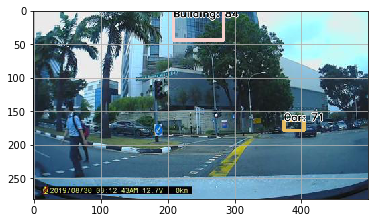

8/105 - resize/test/image1007.jpg


KeyboardInterrupt: 

In [7]:
model_path = "FRCNN_vgg.hdf5"
base_net_type = 'vgg'
im_size = 300                       # shorter-side length. Original is 600, half it to save training time
anchor_box_scales = [64,128,256]    # also half box_scales accordingly. Original is [128,256,512]
anchor_box_ratios = [[1,1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]] # anchor box ratios area == 1
num_rois = 4
num_anchors = len(anchor_box_scales) * len(anchor_box_ratios)

# Load image information
from FRCNN import parseAnnotationFile
annotation_train_path = './annotation_train.txt'
train_data, classes_count, class_mapping = parseAnnotationFile(annotation_train_path)

annotation_test_path = './annotation_test.txt'
test_imgs, _ , _ = parseAnnotationFile(annotation_test_path)


# Create model and load trained weights (Note: class mapping and num_classes should be based on training set)
from FRCNN import FRCNN
frcnn_test = FRCNN(input_shape=(None,None,3), num_anchors=num_anchors, num_rois=num_rois, base_net_type=base_net_type, num_classes = len(classes_count))
frcnn_test.load_config(anchor_box_scales=anchor_box_scales, anchor_box_ratios=anchor_box_ratios, num_rois=num_rois, target_size=im_size)
frcnn_test.load_weights(model_path)
frcnn_test.compile()

# Perform predictions
predicts = frcnn_test.predict(test_imgs, class_mapping=class_mapping, verbose=1)



# evaluate = frcnn_test.evaluate()

# labelname = list(test_it.class_indices.keys())
# predout = np.argmax(predicts, axis = 1)
# scores = metrics.accuracy_score(test_it.labels, predout)
# confusion = metrics.confusion_matrix(test_it.labels, predout)

# print("Best accuracy (on test dataset): %.2f%%" % (scores*100))
# print(metrics.classification_report(test_it.labels, predout, target_names=labelname, digits=4 ))
# print(confusion)
